## Лабораторные 1-3. Кластерный анализ по данным Econom Cities

Активируем все необходимые нам библиотеки для работы. 

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

from sklearn.preprocessing import StandardScaler

#### Загрузка и просмотр данных

Прочитаем данные из файла и сразу посмотрим на них, чтобы понять какие типы данных у нас есть, есть ли пустые значения, выбросы и т.д.

In [3]:
df = pd.read_csv("./Econom_Cities_data.csv", sep=";", decimal = ',', index_col = 'City')
df.head()

,Work,Price,Salary
City,,,
Amsterdam,1714,65.6,49.0
Athens,1792,53.8,30.4
Bogota,2152,37.9,11.5
Bombay,2052,30.3,5.3
Brussels,1708,73.8,50.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, Amsterdam to Zurich
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Work    48 non-null     int64  
 1   Price   48 non-null     float64
 2   Salary  48 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.5+ KB


In [5]:
df.describe()

,Work,Price,Salary
count,48.000000,48.000000,48.000000
mean,1384.958333,68.860417,-378.727083
std,2404.897007,21.784659,2027.338052
min,-9999.000000,30.300000,-9999.000000
25%,1740.750000,49.650000,12.250000
50%,1834.500000,70.500000,40.300000
75%,1972.750000,81.700000,58.700000
max,2375.000000,115.500000,100.000000


Можно заметить по минимальному значению в Work и Salary, что есть данные, которые можно считать выбросами с отрицательными значениями.
Также данные необходимо нормализовать, так как в изначальном виде они в слишком разных диапазонах.

#### Чистим и нормализуем данные

Посмотрим какие данные с отрицательными значениями и уберем их.

In [6]:
df[(df['Work'] < 0) | (df['Salary'] < 0)]

,Work,Price,Salary
City,,,
Cairo,-9999,37.1,-9999.0
Jakarta,-9999,43.6,-9999.0


In [7]:
df = df.drop(['Cairo', 'Jakarta'])

Теперь нормализуем данные при помощи пакета StandardScaler (приведение к нулевому среднему и единичной дисперсии) из модуля preprocessing библиотеки sklearn (новое значение считается по формуле = (старое значение - среднее)/стандартное отклонение. 

fit - посчитает параметры нормализации, а transform - преобразует данные согласно полученным значениям параметров

In [8]:
scaler = StandardScaler()
scaler.fit(df)
ndf = scaler.transform(df)
ndf = pd.DataFrame(ndf, index=df.index, columns=df.columns)

In [9]:
ndf.head()

,Work,Price,Salary
City,,,
Amsterdam,-0.962166,-0.212712,0.386095
Athens,-0.509827,-0.770489,-0.373488
Bogota,1.577891,-1.522069,-1.145323
Bombay,0.997969,-1.881316,-1.398517
Brussels,-0.996961,0.174896,0.447351


### Лабораторная 1. Иерархическая кластеризация 

После того, как привели данные в нормальный вид, можем построить дендрограмму, чтобы посмотреть сколько кластеров можно выделить на этих данных

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
link = linkage(ndf, 'ward', 'euclidean')

Посмотрим на сколько кластеров предлагает делить сам алгоритм (расстояние вычислиться по формуле h = 0.7*max(link[:,2])). 

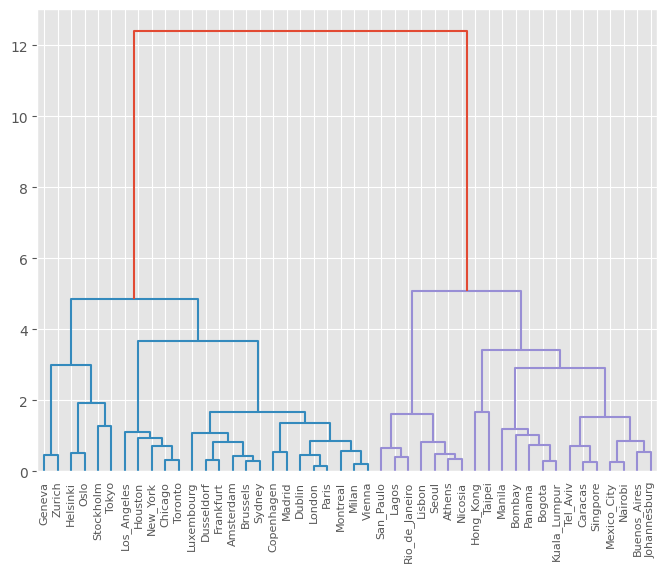

In [26]:
fig = plt.figure(figsize=(8,6))
dn = dendrogram(link, labels= df.index.tolist())
fig

Питон показывает, что тут можно выделить 2 кластера. Посмотрим, как именно он их поделил по данным. 

In [12]:
df['cluster'] = fcluster(link, 2, criterion='maxclust')
df.groupby('cluster').mean()

,Work,Price,Salary
cluster,,,
1,1789.240000,84.972000,59.032000
2,1987.857143,52.395238,16.347619


Питон предложил максимально простое деление на бедные и богатые города.

Теперь, чтобы определить оптимальное количество кластеров, воспользуемся графиком локтя, на котором показывается зависимость расстояний между кластерами от шага объединения (обратного). На графике находим момент, начиная с которого расстояние перестанет значительно меняться.

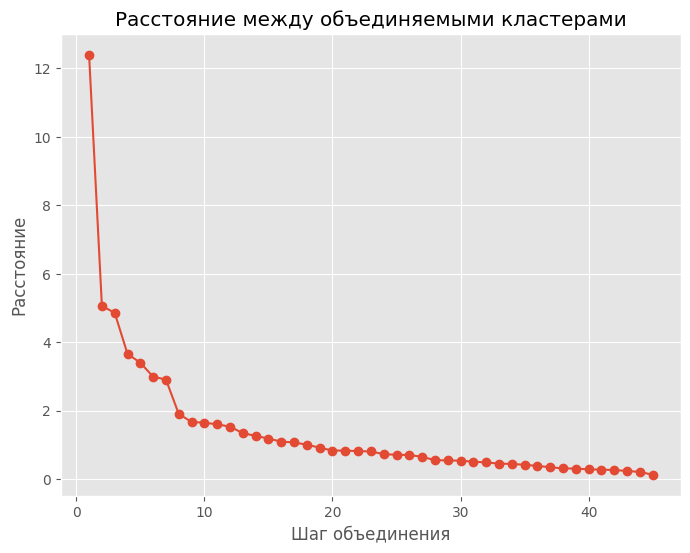

In [28]:
dist = link[:, 2]
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.figure(figsize=(8,6))
plt.plot(idxs, dist_rev, marker='o')
plt.title('Расстояние между объединяемыми кластерами')
plt.xlabel('Шаг объединения')
plt.ylabel('Расстояние')
plt.show()

По диаграмме можно заметить, что максимальное деление на кластеры, которое будет содержательным, это деление на 4 кластера. 

Еще раз посмотрим на дендрограмму с уже подкрашенными кластерами и перейдем к интерпретации данного разделения. 

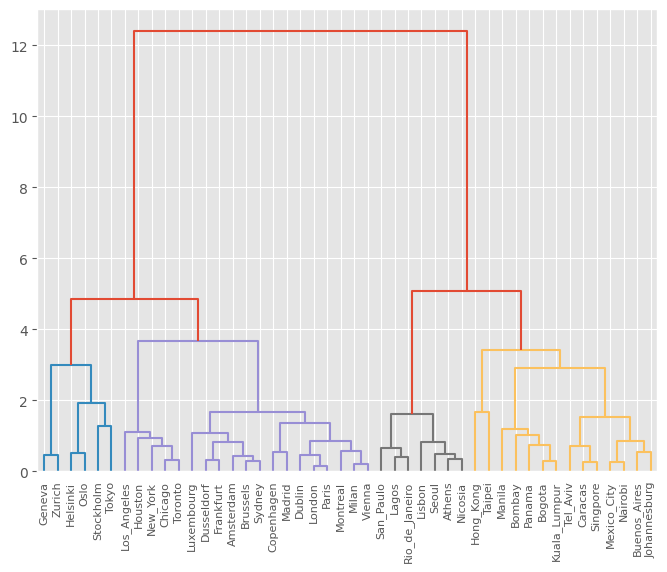

In [29]:
fig = plt.figure(figsize=(8,6))
dn = dendrogram(link, labels= df.index.tolist(),color_threshold=4)
fig

In [30]:
df['cluster'] = fcluster(link, 4, criterion='maxclust')
df.groupby('cluster').mean().round(2)

,Work,Price,Salary
cluster,,,
1,1780.50,108.55,71.30
2,1792.00,77.53,55.16
3,1798.86,50.94,19.21
4,2082.36,53.12,14.91


#### Интрепретация полученных кластеров

Таким образом, можно выделить следующие группы городов: 

1. **Развитые и дорогие.** В таких городах высокие цены, при том, что люди работают меньше других, но получают больше заработной платы. (Женева, Цюрих, Токио и тд.)
2. **Средний класс.** Города, в которых умеренные цены и доходы, стабильный и комфортный уровень жизни. (Нью Йорк, Париж, Сидней и тд.)
3. **Активно развивающиеся.** Более дешёвые города, где люди работают чуть больше, заработки ниже, но расходы также ниже. (Сан-Паоло, Сеул, Рио-де-Жанейро и тд.)
4. **Низкоразвитые.** Страны с дешёвой рабочей силой, где люди работают много, но получают мало, при этом стоимость жизни даже дороже чем в развивающихся. (Манила, Сингапур, Найроби и тд.)

### Лабораторная 2. Кластерный анализ методом к-средних (k-means)

In [17]:
from sklearn.cluster import KMeans

Посмотрим, какое число кластеров будет оптимальным по данному методу.

Применим модель для разного числа кластеров, чтобы построить график каменистой осыпи. Метод inertia_ вернёт сумму квадратов расстояний от каждой точки данных до центра ближайшего к ней кластера. Кластеризацию будем считать условно хорошей, если инерция перестаёт сильно уменьшаться при увеличении числа кластеров.

Пусть нам построят модели для ситуаций от 2 до 24 кластеров.

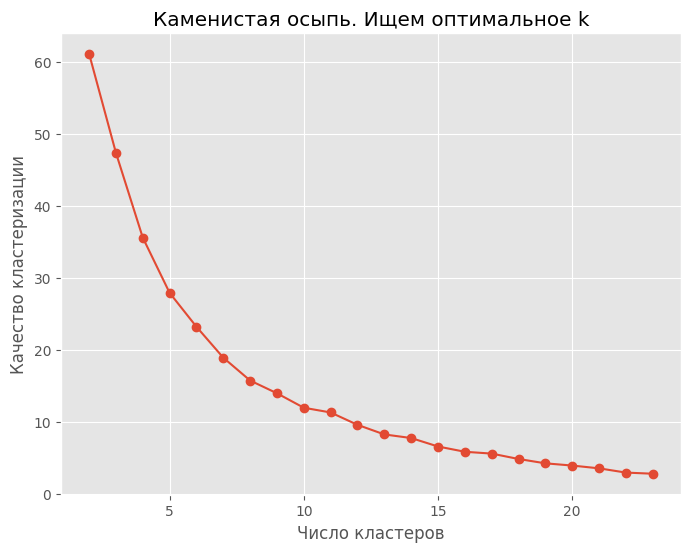

In [32]:
K = range(2, 24)
models = [KMeans(n_clusters=k, random_state=42, max_iter=300, n_init=10, 
               verbose=0, tol=0.0001).fit(ndf) for k in K]
dist = [model.inertia_ for model in models]
plt.figure(figsize=(8,6))
plt.plot(K, dist, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Качество кластеризации')
plt.title('Каменистая осыпь. Ищем оптимальное k')

plt.show()

Можно заметить по диаграмме, что после 4-5 кластера падение замедляется, что свидетельствует о том, что количество оптимальных кластеров 4-5.

Так как при иерархической кластеризации мы рассмотрели случай с 4 кластерами, посмотрим на разбиение на 5.

In [20]:
model = KMeans(n_clusters=5, random_state=42, max_iter=300, n_init=10, verbose=0)
model.fit(ndf)
df['cluster'] = model.labels_
df.groupby('cluster').mean()

,Work,Price,Salary
cluster,,,
0,2146.875000,48.762500,12.412500
1,1990.833333,77.233333,55.316667
2,1732.000000,78.135714,53.614286
3,1868.750000,52.158333,17.458333
4,1780.500000,108.550000,71.300000


#### Интрепретация полученных кластеров

0. ***Трудовые мегаполисы***, где много работают при низких ценах и зарплатах.
1. ***Сбалансированные центры*** с умеренными ценами и достойной оплатой труда.
2. ***Развивающиеся города*** с чуть меньшими зарплатами и похожим уровнем цен.
3. ***Дешёвые трудовые рынки*** с низкими ценами и низкими доходами.
4. ***Богатые столицы***  с самыми высокими зарплатами и коротким рабочим годом.


По сравнению с предыдущим разделением кластер с неразвитыми городами разделился на те, в которых очень много работают за минимальную оплату, и те, в которых работают примерно столько же в среднем, но цены и зарплаты значительно ниже. 

## Лабораторная 3. Кластерный анализ методом DBSCAN


Попорбуем эмпирически подобрать необходимые параметры.

Количество минимальных точек в окрестности определим по приницпу того, что она должна быть больше размерности данных на 1. В нашем случае получается 4.

In [21]:
min_samples = ndf.shape[1] + 1
min_samples

4

Для определения подходящего eps используем метод локтя.

Выбираем значение минимального количества соседей (то есть минимальное количество точек в окрестности - 1) = 3

Вычисляем среднее расстояние по 3 ближайшим соседям для каждой точки, т.е. нужно выбрать трёх ближайших соседей, сложить расстояния до них и поделить на три. Для этого используем метод NearestNeighbors из пакета sklearn.

Сортируем полученные значения по возрастанию и выводим в формате графика локтя.

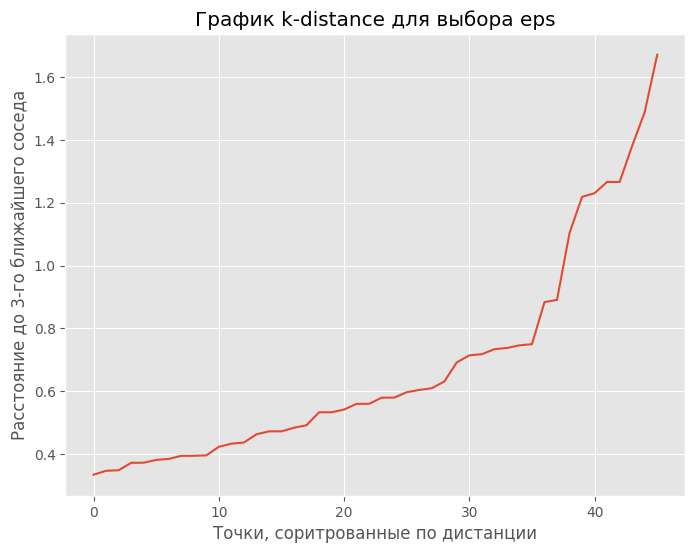

In [33]:
from sklearn.neighbors import NearestNeighbors

k = min_samples - 1
nn = NearestNeighbors(n_neighbors = k).fit(ndf)
distances, indices = nn.kneighbors(ndf)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8,6))
plt.plot(k_distances)
plt.ylabel(f'Расстояние до {k}-го ближайшего соседа')
plt.xlabel('Точки, соритрованные по дистанции')
plt.title('График k-distance для выбора eps')
plt.show()

Можно заметить, что "сгиб" локтя начинается где-то около 0.8, поэтому это значение мы и возьмем за eps.

Построим модель кластеризации методом DBSCAN с полученными параметрами и посмотрим, как разделились наши данные.

In [34]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.8, min_samples = min_samples, metric='euclidean')
labels = db.fit_predict(ndf)
unique, counts = np.unique(db.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

[[-1  8]
 [ 0 19]
 [ 1 19]]


Таким образом, у нас получилось 2 кластера по 19 городов и 8 выбросов. Я считаю, что такие параметры оптимальны для данного датасета, так как при их сильном изменении мы либо получаем слишком много выбросов, либо слишком маленькие кластеры по 2-3 города.

Как дополнительный бонус, я спросила у ИИ, как можно визуализировать результаты метода DBSCAN. Можно написовать точечную диаграмму рассеивания с подкрашиванием кластеров, только для этого придется сначала понизить размерность методом главных компонент.

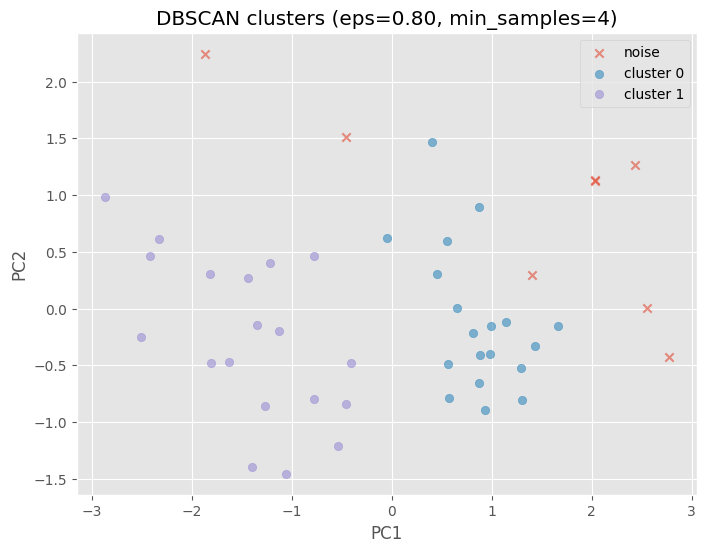

In [38]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)
X2 = pca.fit_transform(ndf)

plt.figure(figsize=(8,6))
unique_labels = np.unique(labels)
for lab in unique_labels:
    pts = X2[labels == lab]
    if lab == -1:
        plt.scatter(pts[:,0], pts[:,1], marker='x', label='noise', alpha=0.6)
    else:
        plt.scatter(pts[:,0], pts[:,1], label=f'cluster {lab}', alpha=0.6)
plt.legend()
plt.title(f'DBSCAN clusters (eps={0.8:.2f}, min_samples={min_samples})')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

Теперь самостоятельно посмотрим, что за кластеры получились после применения метода.

In [39]:
df['dbscan'] = db.labels_
df.groupby('dbscan').mean()

,Work,Price,Salary,cluster
dbscan,,,,
-1,1900.375000,99.925000,61.262500,1.750000
0,1792.000000,77.526316,55.157895,2.000000
1,1959.210526,50.115789,14.789474,3.631579


#### Интерпретация полученных результатов

-1 - Группа ***аномалий и выбросов*** среди городов, при этом можно сказать, что это города со высокими ценами и высокими зарплатами, при этом средним числом рабочих часов

1 - ***Сбалансированные города*** со средними ценами и относительно высокими зарплатами, при умеренной занятости.

2 - ***Трудовые города***, где работают больше, но при этом цены и зарплаты низкие.

### Общие выводы по 1-3 лабораторным по кластеризации

Все три метода показали похожие экономические тенденции (богатые, средние и низкодоходные города).

Иерархическая и K-Means дали схожие результаты по группировке.

DBSCAN подтвердил наличие двух основных типов городов и выделил аномально богатые города как отдельный шум.

Для такой задачи DBSCAN полезен для обнаружения «исключительных» городов, а K-Means или иерархическая кластеризация — для общего группирования и анализа структуры.